### Load Dataset and Visualisation

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import re

In [14]:
#| echo: true
#| output: true

df = pd.read_csv(r"C:\Users\USER\Downloads\ufc_clean_no_duplicates.csv")
HTML(df.head(10).to_html())

,Fighter,W/L,Opponent,Knockdowns,Strikes,Takedowns,SubmissionAttempts,Event,Method,Round,Date,First Name,Last Name,Link,Nick Name,Wins,Losses,Draws,Height,Weight,Reach,STANCE,DOB,SLpM,Str. Acc.,SApM,Str. Def,TD Avg.,TD Acc.,TD Def.,Sub. Avg.
0,tom aaron,loss,Matt Ricehouse,--,--,--,--,"Strikeforce - Henderson vs. Babalu Dec. 04, 2010",U-DEC,3.0,7/12/2005,Tom,Aaron,http://ufcstats.com/fighter-details/93fe7332d16c6ad9,NaN,5.0,3.0,0,--,155 lbs.,--,NaN,7/13/1978,0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,tom aaron,win,Eric Steenberg,--,--,--,--,"Strikeforce - Heavy Artillery May. 15, 2010",SUB,1.0,7/15/2009,Tom,Aaron,http://ufcstats.com/fighter-details/93fe7332d16c6ad9,NaN,5.0,3.0,0,--,155 lbs.,--,NaN,7/13/1978,0.00,0%,0.00,0%,0.00,0%,0%,0.0
2,danny abbadi,loss,Jorge Gurgel,0,56,0,0,"UFC 63: Hughes vs Penn Sep. 23, 2006",S-DEC,3.0,1/1/1999,Danny,Abbadi,http://ufcstats.com/fighter-details/15df64c02b6b0fde,The Assassin,4.0,6.0,0,"5' 11""",155 lbs.,--,Orthodox,7/3/1983,3.29,38%,4.41,57%,0.00,0%,77%,0.0
3,danny abbadi,loss,Kalib Starnes,0,3,0,0,"The Ultimate Fighter: Team Ortiz vs. Team Shamrock Finale Jun. 24, 2006",SUB,1.0,1/1/2012,Danny,Abbadi,http://ufcstats.com/fighter-details/15df64c02b6b0fde,The Assassin,4.0,6.0,0,"5' 11""",155 lbs.,--,Orthodox,7/3/1983,3.29,38%,4.41,57%,0.00,0%,77%,0.0
4,nariman abbasov,loss,Ismael Bonfim,0,45,0,0,"DWCS 6.7 Sep. 06, 2022",U-DEC,3.0,1/1/2012,Nariman,Abbasov,http://ufcstats.com/fighter-details/59a9d6dac61c2540,Bayraktar,28.0,4.0,0,"5' 8""",155 lbs.,"66""",Orthodox,2/1/1994,3.00,20%,5.67,46%,0.00,0%,66%,0.0
5,david abbott,loss,Kevin Ferguson,0,1,0,0,"EliteXC - Street Certified Feb. 16, 2008",KO/TKO,1.0,1/1/2000,David,Abbott,http://ufcstats.com/fighter-details/b361180739bed4b0,Tank,10.0,15.0,0,"6' 0""",265 lbs.,--,Switch,4/26/1965,1.35,30%,3.55,38%,1.07,33%,66%,0.0
6,david abbott,loss,Paul Buentello,0,4,0,0,"Strikeforce - Tank vs. Buentello Oct. 07, 2006",KO/TKO,1.0,1/1/1995,David,Abbott,http://ufcstats.com/fighter-details/b361180739bed4b0,Tank,10.0,15.0,0,"6' 0""",265 lbs.,--,Switch,4/26/1965,1.35,30%,3.55,38%,1.07,33%,66%,0.0
7,david abbott,loss,Hidehiko Yoshida,0,2,1,0,"PRIDE Final Conflict 2005 Aug. 28, 2005",SUB,1.0,1/1/2020,David,Abbott,http://ufcstats.com/fighter-details/b361180739bed4b0,Tank,10.0,15.0,0,"6' 0""",265 lbs.,--,Switch,4/26/1965,1.35,30%,3.55,38%,1.07,33%,66%,0.0
8,david abbott,loss,Wesley Correira,0,11,0,0,"UFC 45: Revolution Nov. 21, 2003",KO/TKO,1.0,1/1/2003,David,Abbott,http://ufcstats.com/fighter-details/b361180739bed4b0,Tank,10.0,15.0,0,"6' 0""",265 lbs.,--,Switch,4/26/1965,1.35,30%,3.55,38%,1.07,33%,66%,0.0
9,david abbott,loss,Kimo Leopoldo,0,0,0,0,"UFC 43: Meltdown Jun. 06, 2003",SUB,1.0,1/1/2003,David,Abbott,http://ufcstats.com/fighter-details/b361180739bed4b0,Tank,10.0,15.0,0,"6' 0""",265 lbs.,--,Switch,4/26/1965,1.35,30%,3.55,38%,1.07,33%,66%,0.0


In [53]:
# Show columns to verify
print("Columns in dataset:", df.columns.tolist())

Columns in dataset: ['Fighter', 'W/L', 'Opponent', 'Knockdowns', 'Strikes', 'Takedowns', 'SubmissionAttempts', 'Event', 'Method', 'Round', 'Date', 'First Name', 'Last Name', 'Link', 'Nick Name', 'Wins', 'Losses', 'Draws', 'Height', 'Weight', 'Reach', 'STANCE', 'DOB', 'SLpM', 'Str. Acc.', 'SApM', 'Str. Def', 'TD Avg.', 'TD Acc.', 'TD Def.', 'Sub. Avg.', 'Strikes_Landed', 'Strikes_Attempted', 'Weight_Clean', 'Weight_Class', 'Fight_Seconds', 'Win_Method_Simple']


# Distribution of Knockdowns

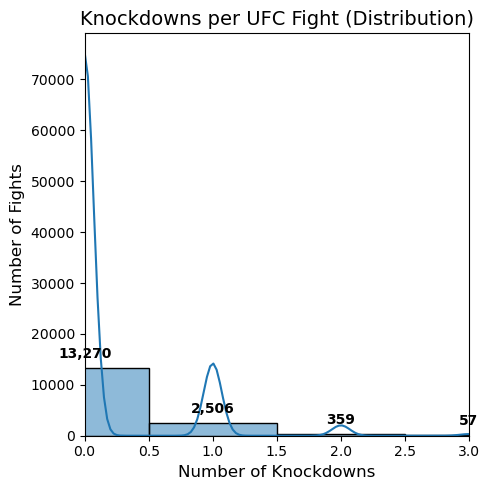

In [57]:
#1.Distribution of Knockdowns: Plot a histogram to see how often knockdowns occur

# Ensure Knockdowns column is numeric
df['Knockdowns'] = pd.to_numeric(df['Knockdowns'], errors='coerce')

# Determine max knockdowns
max_knockdowns = int(df['Knockdowns'].max())

# Create the plot
plt.figure(figsize=(5, 5))
ax = sns.histplot(data=df, x='Knockdowns', bins=range(0, max_knockdowns + 2), discrete=True, kde=True)

# Set labels and titles
plt.title('Knockdowns per UFC Fight (Distribution)', fontsize=14)
plt.xlabel('Number of Knockdowns', fontsize=12)
plt.ylabel('Number of Fights', fontsize=12)
plt.xlim(0, 3)

# Add value labels on bars
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{int(height):,}',  # Adds commas for thousands
                    xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 5),  # Increased offset for clarity
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

color= 'darkblue'


plt.tight_layout()
plt.show()

In [20]:
# Fixed extraction function
def safe_extract_strikes(strikes_str):
    if pd.isna(strikes_str) or str(strikes_str) == '--':
        return pd.Series([None, None])
    
    # Try the most common patterns
    match = re.search(r'(\d+).*?(\d+)', str(strikes_str))
    if match:
        return pd.Series([int(match.group(1)), int(match.group(2))])
    return pd.Series([None, None])

# Apply the extraction
df[['Strikes_Landed', 'Strikes_Attempted']] = df['Strikes'].apply(safe_extract_strikes)

# Check the results
print("Sample of extracted data:")
df[['Fighter', 'Strikes', 'Strikes_Landed', 'Strikes_Attempted']].head(10)


Sample of extracted data:


,Fighter,Strikes,Strikes_Landed,Strikes_Attempted
0,tom aaron,--,NaN,NaN
1,tom aaron,--,NaN,NaN
2,danny abbadi,56,5.0,6.0
3,danny abbadi,3,NaN,NaN
4,nariman abbasov,45,4.0,5.0
5,david abbott,1,NaN,NaN
6,david abbott,4,NaN,NaN
7,david abbott,2,NaN,NaN
8,david abbott,11,1.0,1.0
9,david abbott,0,NaN,NaN


In [21]:
# Check extraction success
successful = df['Strikes_Landed'].notna().sum()
print(f"\nSuccessful extractions: {successful} out of {len(df)}")

if successful > 0:
    print(f"Strikes_Landed range: {df['Strikes_Landed'].min()} to {df['Strikes_Landed'].max()}")



Successful extractions: 15842 out of 21508
Strikes_Landed range: 1.0 to 44.0


In [22]:
# Remove the indentation - run this code directly
top_strikers = df.groupby('Fighter')['Strikes_Landed'].sum().sort_values(ascending=False).head(10)
print("Top 10 Fighters by Total Strikes Landed:")
print(top_strikers)

Top 10 Fighters by Total Strikes Landed:
Fighter
max holloway          333.0
sean strickland       210.0
angela hill           200.0
king green            185.0
donald cerrone        184.0
nick diaz             174.0
cub swanson           169.0
joanna jedrzejczyk    169.0
rafael dos anjos      168.0
frankie edgar         168.0
Name: Strikes_Landed, dtype: float64


In [23]:
# Check if we have meaningful data
if top_strikers.max() > 0:
    print(f"\nHighest total: {top_strikers.max()} strikes")
    print(f"Non-zero fighters: {(top_strikers > 0).sum()}")


Highest total: 333.0 strikes
Non-zero fighters: 10


# 2. Top 10 Fighters by Total Strikes Landed

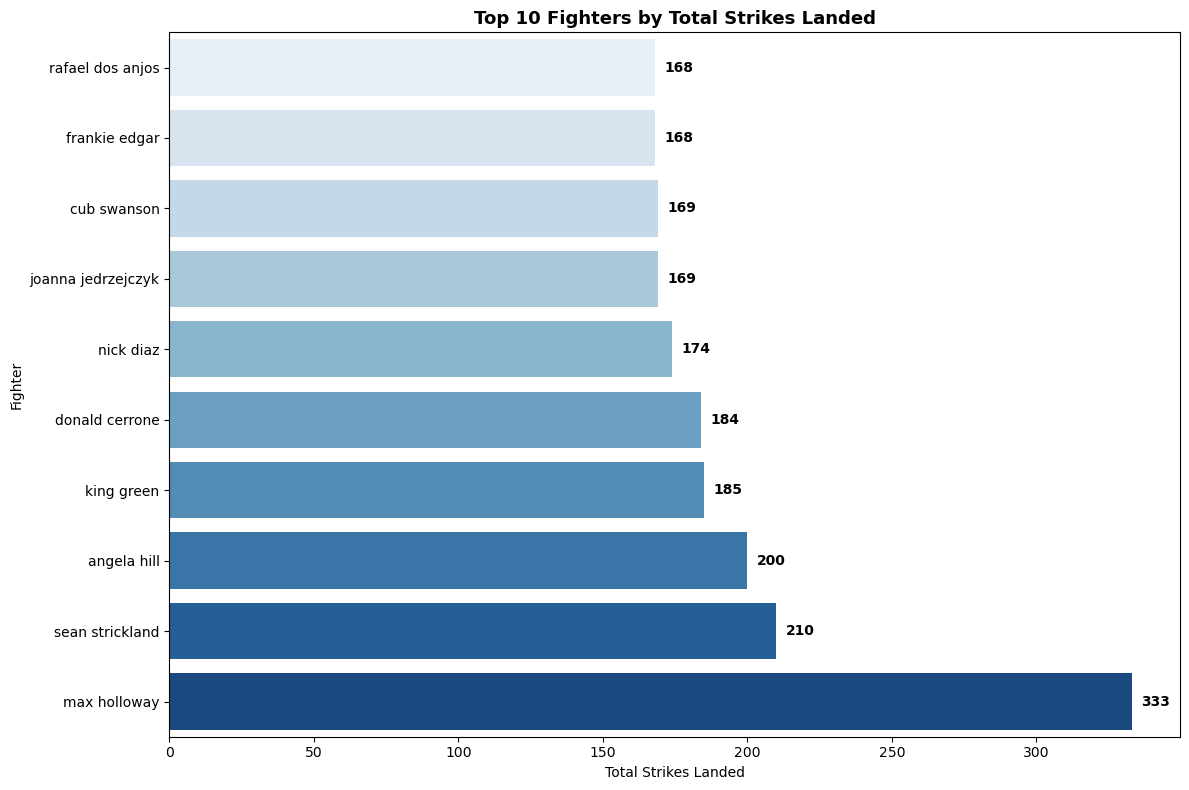

In [24]:
#2 Top 10 Fighters by Total Strikes Landed
top_strikers = top_strikers.sort_values(ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_strikers.values, y=top_strikers.index, palette='Blues', orient='h')
plt.title('Top 10 Fighters by Total Strikes Landed', fontsize=13, fontweight='bold')
plt.xlabel('Total Strikes Landed', fontsize=10)
plt.ylabel('Fighter', fontsize=10)

 
for i, v in enumerate(top_strikers.values):
    plt.text(v + max(top_strikers.values) * 0.01, i, f'{int(v)}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

 
if top_strikers.max() == 0:
    print("All values are still zero - extraction may have failed")
    print("Let's check the data format:")
    print(df[['Fighter', 'Strikes', 'Strikes_Landed', 'Strikes_Attempted']].head())


In [25]:
# Convert 'Weight' ('155 lbs.') to numeric (155)
# Clean the 'Weight' column
df['Weight_Clean'] = df['Weight'].str.extract(r'(\d+)').astype(float)

In [26]:
#Map to standard UFC divisions
weight_class_map = {
    115: 'Strawweight', 125: 'Flyweight', 135: 'Bantamweight',
    145: 'Featherweight', 155: 'Lightweight', 170: 'Welterweight',
    185: 'Middleweight', 205: 'Light Heavyweight', 265: 'Heavyweight'
}
df['Weight_Class'] = df['Weight_Clean'].map(weight_class_map)

In [27]:
#Drop rows where class couldn't be mapped
df = df.dropna(subset=['Weight_Class'])

In [28]:
#Estimate fight length (300 seconds = 5 minutes per round)
df = df[df['Round'].notna() & (df['Round'] > 0)].copy()
df['Fight_Seconds'] = df['Round'] * 300

In [29]:
# Group by weight class
avg_fight_length = df.groupby('Weight_Class')['Fight_Seconds'].mean().sort_values()

# 3. Average Fight Length by Weight Class

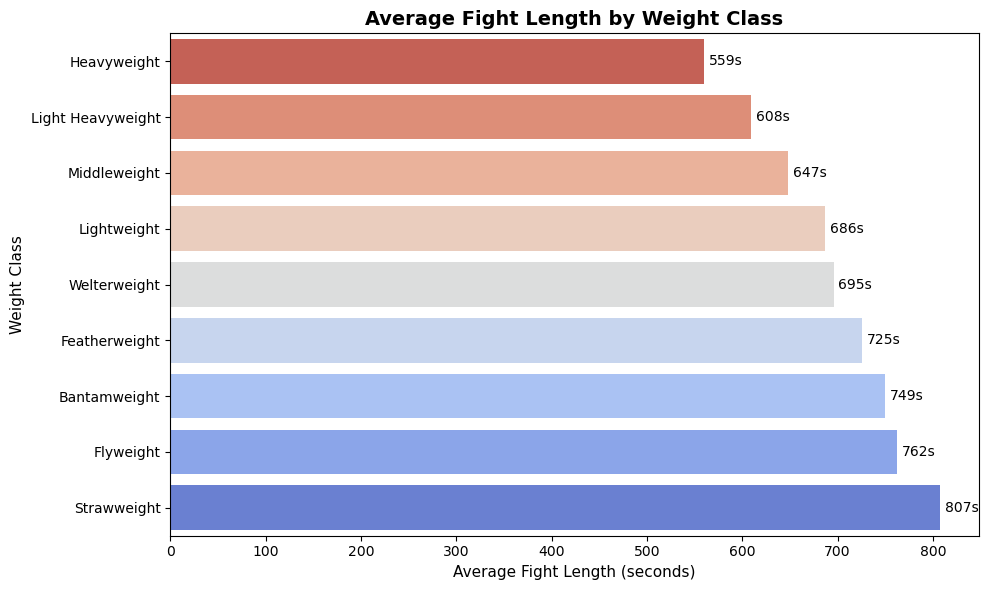

In [30]:
#3. Average Fight Length by Weight Class: Compare fight durations across division
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_fight_length.values, y=avg_fight_length.index, palette='coolwarm_r')
plt.title('Average Fight Length by Weight Class', fontsize=14, fontweight='bold')
plt.xlabel('Average Fight Length (seconds)', fontsize=11)
plt.ylabel('Weight Class', fontsize=11)

# Add labels on bars
for i, v in enumerate(avg_fight_length.values):
    plt.text(v + 5, i, f'{int(v)}s', va='center')

plt.tight_layout()
plt.show()

In [31]:
#4. Win Method Trends: Create a pie chart or bar chart showing the proportion of wins by KO, submission, or decision.
def simplify_method(method):
    method = str(method).upper()  # Handle NaNs & lowercase
    if 'KO' in method:
        return 'KO/TKO'
    elif 'SUB' in method:
        return 'Submission'
    elif 'DEC' in method:
        return 'Decision'
    elif 'DQ' in method:
        return 'Disqualification'
    elif 'OVERTURNED' in method:
        return 'Overturned'
    else:
        return 'Other'

In [32]:
df['Win_Method_Simple'] = df['Method'].apply(simplify_method)
df['Win_Method_Simple']

0          Decision
1        Submission
2          Decision
3        Submission
4          Decision
            ...    
21501      Decision
21502    Submission
21503    Submission
21504      Decision
21505      Decision
Name: Win_Method_Simple, Length: 16694, dtype: object

In [33]:
#Count and sort
method_counts = df['Win_Method_Simple'].value_counts()
method_counts

Decision            7652
KO/TKO              5338
Submission          3470
Overturned           110
Other                 79
Disqualification      45
Name: Win_Method_Simple, dtype: int64

# 4. Win Method Trends

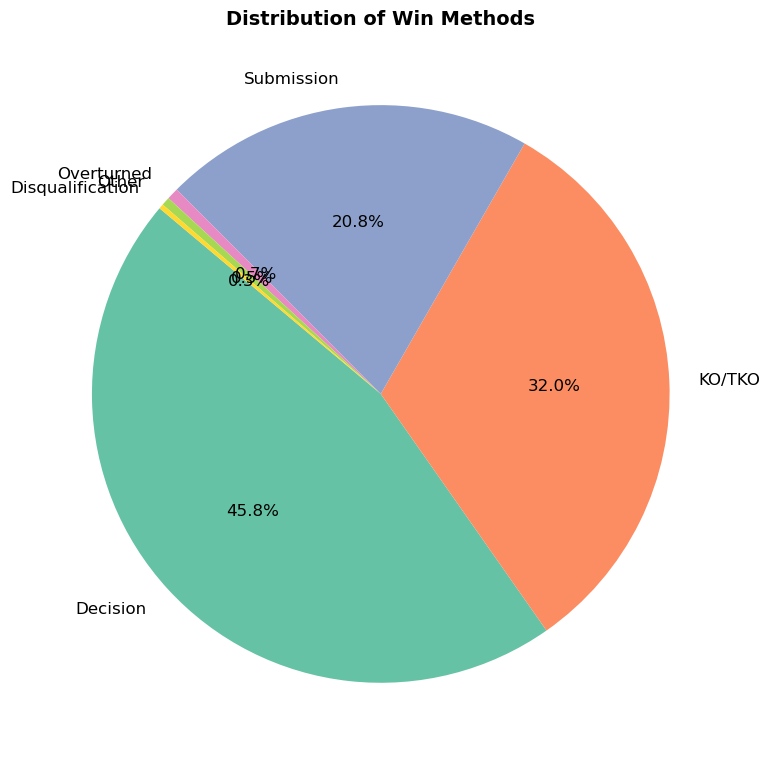

In [34]:
# Win Method Trends:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('Set2', n_colors=len(method_counts))
method_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
plt.ylabel('')
plt.title('Distribution of Win Methods', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [35]:
# Fight Frequency Over Time: Visualize how active fighters are across their careers.
# Check Date column
print(df['Date'].head())  # See the format of the date values


0    7/12/2005
1    7/15/2009
2     1/1/1999
3     1/1/2012
4     1/1/2012
Name: Date, dtype: object


In [36]:
#Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'coerce' will turn invalid dates into NaT
df['Date']

0       2005-07-12
1       2009-07-15
2       1999-01-01
3       2012-01-01
4       2012-01-01
           ...    
21501   2020-01-01
21502   2003-01-01
21503   2003-01-01
21504   2022-01-01
21505   2009-01-01
Name: Date, Length: 16694, dtype: datetime64[ns]

In [37]:
# Optional check: see if conversion worked
print("Sample converted dates:\n", df['Date'].dropna().head())

Sample converted dates:
 0   2005-07-12
1   2009-07-15
2   1999-01-01
3   2012-01-01
4   2012-01-01
Name: Date, dtype: datetime64[ns]


In [38]:
# STEP 2: Drop rows with missing dates
df_clean = df[df['Date'].notna()].copy()
df_clean

,Fighter,W/L,Opponent,Knockdowns,Strikes,Takedowns,SubmissionAttempts,Event,Method,Round,...,TD Avg.,TD Acc.,TD Def.,Sub. Avg.,Strikes_Landed,Strikes_Attempted,Weight_Clean,Weight_Class,Fight_Seconds,Win_Method_Simple
0,tom aaron,loss,Matt Ricehouse,NaN,--,--,--,Strikeforce - Henderson vs. Babalu ...,U-DEC,3.0,...,0.0,0%,0%,0.0,NaN,NaN,155.0,Lightweight,900.0,Decision
1,tom aaron,win,Eric Steenberg,NaN,--,--,--,Strikeforce - Heavy Artillery ...,SUB,1.0,...,0.0,0%,0%,0.0,NaN,NaN,155.0,Lightweight,300.0,Submission
2,danny abbadi,loss,Jorge Gurgel,0.0,56,0,0,UFC 63: Hughes vs Penn ...,S-DEC,3.0,...,0.0,0%,77%,0.0,5.0,6.0,155.0,Lightweight,900.0,Decision
3,danny abbadi,loss,Kalib Starnes,0.0,3,0,0,The Ultimate Fighter: Team Ortiz vs. Team Sham...,SUB,1.0,...,0.0,0%,77%,0.0,NaN,NaN,155.0,Lightweight,300.0,Submission
4,nariman abbasov,loss,Ismael Bonfim,0.0,45,0,0,DWCS 6.7 Sep...,U-DEC,3.0,...,0.0,0%,66%,0.0,4.0,5.0,155.0,Lightweight,900.0,Decision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21501,chris lytle,loss,Karo Parisyan,0.0,7\n,0\n,2\n,UFC 51: Super Saturday\n \n\n\n ...,U-DEC,3.0,...,0.7,55%,55%,2.4,NaN,NaN,170.0,Welterweight,900.0,Decision
21502,chris lytle,win,Ronald Jhun,1.0,12\n,0\n,2\n,UFC 49: Unfinished Business\n \n\n\n ...,SUB\n,2.0,...,0.7,55%,55%,2.4,1.0,2.0,170.0,Welterweight,600.0,Submission
21503,chris lytle,win,Tiki Ghosn,0.0,34\n,2\n,1\n,UFC 47: It's On!\n \n\n\n \n...,SUB\n,2.0,...,0.7,55%,55%,2.4,3.0,4.0,170.0,Welterweight,600.0,Submission
21504,chris lytle,loss,Robbie Lawler,0.0,37\n,1\n,1\n,UFC 45: Revolution\n \n\n\n ...,U-DEC,3.0,...,0.7,55%,55%,2.4,3.0,7.0,170.0,Welterweight,900.0,Decision


In [44]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0       2005-07-12
1       2009-07-15
2       1999-01-01
3       2012-01-01
4       2012-01-01
           ...    
21501   2020-01-01
21502   2003-01-01
21503   2003-01-01
21504   2022-01-01
21505   2009-01-01
Name: Date, Length: 16694, dtype: datetime64[ns]

In [48]:
fights_per_year_count = df[df['Date'].dt.year >= 1998]['Date'].dt.year.value_counts().sort_index()
fights_per_year_count

1998     935
1999     916
2000    1858
2001       4
2003    1847
2005     924
2009    1859
2012    1839
2020     915
2022     928
2023    1885
2024       4
Name: Date, dtype: int64

In [50]:
fights_per_year_df = fights_per_year_count.reset_index()
fights_per_year_df.columns = ['Year', 'Fights']
fights_per_year_df.columns

Index(['Year', 'Fights'], dtype='object')

## 5. Fight Frequency Over Time

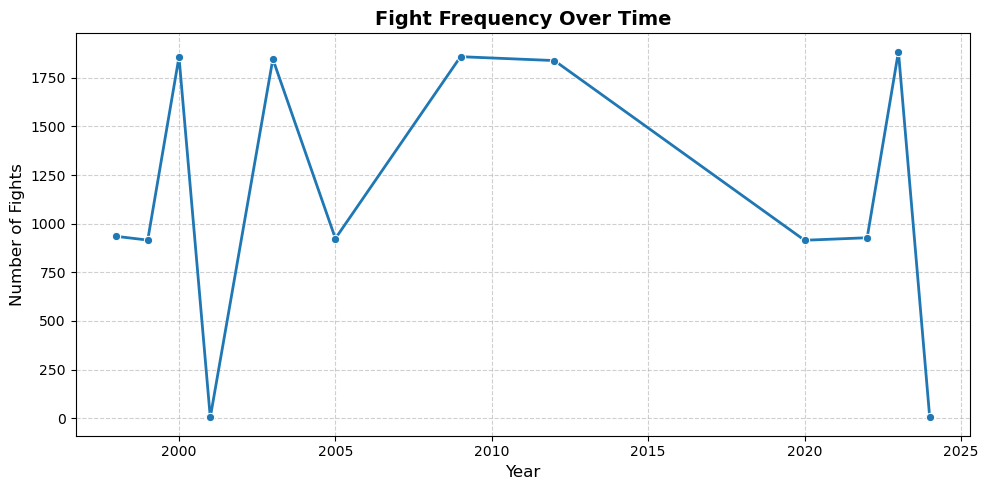

In [51]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fights_per_year_df, x='Year', y='Fights', marker='o', linewidth=2)
plt.title('Fight Frequency Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Fights', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()